# CIFAR-100 — 4 Model Karşılaştırması (12 Epoch)

Bu notebook, **aynı backbone** ile 4 farklı regularization ayarını karşılaştırır:

1. **none** (baseline)
2. **dropout** (`nn.Dropout`)
3. **spatial_dropout** (`nn.Dropout2d`)
4. **stochastic_depth** (residual branch drop, sample-wise)

✅ Aynı: model yapısı, optimizer/LR/WD, augmentations, epoch sayısı (12).

> Not: Windows'ta `NUM_WORKERS=0` daha stabil olabilir.


In [1]:

# ===== 0) Imports / Seed / Device =====
import os, random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


device: cuda


In [2]:

# ===== 1) CIFAR-100 Data =====
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

train_ds = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=train_tf)
test_ds  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tf)

BATCH_SIZE = 128
NUM_WORKERS = 2  # Windows'ta sorun olursa 0 yap

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("train:", len(train_ds), "test:", len(test_ds))


Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


## 2) Regularizer Modülleri

- Dropout & Spatial Dropout: **Conv-BN-Act sonrası**
- Stochastic Depth: **residual branch** üzerinde (`out = SD(F(x))`, `y = x + out`)


In [3]:

# ===== 2) Regularizers =====
class StochasticDepth(nn.Module):
    """Sample-wise stochastic depth. Mask: [B,1,1,1...]"""
    def __init__(self, p: float = 0.0):
        super().__init__()
        if not (0.0 <= p < 1.0):
            raise ValueError("p must be in [0,1).")
        self.p = float(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if (not self.training) or self.p == 0.0:
            return x
        q = 1.0 - self.p
        shape = (x.size(0),) + (1,) * (x.ndim - 1)  # (B,1,1,1...)
        mask = torch.empty(shape, device=x.device, dtype=x.dtype).bernoulli_(q)
        return x * mask / q


def sd_linear_schedule(total_blocks: int, p_max: float):
    """p_i = p_max * i/(L-1)"""
    if total_blocks <= 1:
        return [p_max]
    return [p_max * i / (total_blocks - 1) for i in range(total_blocks)]


## 3) Aynı Backbone (TinyResNet-benzeri)

Toplam **6 residual block** var:
- stage1: 2 blok (32)
- stage2: 2 blok (64)
- stage3: 2 blok (128)

Sadece şu parametreler değişiyor:
- `drop_type`: none / dropout / spatial
- `drop_p`: dropout olasılığı
- `sd_max`: stochastic depth maksimum p (blok index’iyle lineer artar)


In [4]:

# ===== 3) Backbone =====
class ConvBNAct(nn.Module):
    def __init__(self, cin, cout, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        self.act = nn.SiLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class ConvBNActDrop(nn.Module):
    """drop_type: 'none' | 'dropout' | 'spatial'"""
    def __init__(self, cin, cout, k=3, s=1, p=1, drop_p=0.0, drop_type="none"):
        super().__init__()
        self.core = ConvBNAct(cin, cout, k, s, p)

        if drop_p <= 0 or drop_type == "none":
            self.drop = nn.Identity()
        elif drop_type == "dropout":
            self.drop = nn.Dropout(p=drop_p)
        elif drop_type == "spatial":
            self.drop = nn.Dropout2d(p=drop_p)
        else:
            raise ValueError("drop_type must be: none/dropout/spatial")

    def forward(self, x):
        x = self.core(x)
        x = self.drop(x)
        return x


class BasicResBlock(nn.Module):
    """Same residual block; only regularizers differ."""
    def __init__(self, cin, cout, stride=1, drop_type="none", drop_p=0.0, sd_p=0.0):
        super().__init__()
        self.conv1 = ConvBNActDrop(cin, cout, k=3, s=stride, p=1, drop_p=drop_p, drop_type=drop_type)
        self.conv2 = nn.Sequential(
            nn.Conv2d(cout, cout, 3, padding=1, bias=False),
            nn.BatchNorm2d(cout)
        )

        self.sd = StochasticDepth(p=sd_p)

        self.shortcut = nn.Identity()
        if stride != 1 or cin != cout:
            self.shortcut = nn.Sequential(
                nn.Conv2d(cin, cout, 1, stride=stride, bias=False),
                nn.BatchNorm2d(cout)
            )

        self.act = nn.SiLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.sd(out)          # ✅ SD branch-level
        out = self.act(out + identity)
        return out


class TinyResNetSameBackbone(nn.Module):
    def __init__(self, num_classes=100, drop_type="none", drop_p=0.0, sd_max=0.0):
        super().__init__()
        total_blocks = 6
        sd_probs = sd_linear_schedule(total_blocks, sd_max) if sd_max > 0 else [0.0]*total_blocks
        idx = 0

        self.stem = ConvBNActDrop(3, 32, k=3, s=1, p=1, drop_p=drop_p, drop_type=drop_type)

        self.b1 = BasicResBlock(32, 32, 1, drop_type, drop_p, sd_probs[idx]); idx += 1
        self.b2 = BasicResBlock(32, 32, 1, drop_type, drop_p, sd_probs[idx]); idx += 1

        self.b3 = BasicResBlock(32, 64, 2, drop_type, drop_p, sd_probs[idx]); idx += 1
        self.b4 = BasicResBlock(64, 64, 1, drop_type, drop_p, sd_probs[idx]); idx += 1

        self.b5 = BasicResBlock(64, 128, 2, drop_type, drop_p, sd_probs[idx]); idx += 1
        self.b6 = BasicResBlock(128, 128, 1, drop_type, drop_p, sd_probs[idx]); idx += 1

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.b1(x); x = self.b2(x)
        x = self.b3(x); x = self.b4(x)
        x = self.b5(x); x = self.b6(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

# quick shape test
m = TinyResNetSameBackbone(num_classes=100, drop_type="spatial", drop_p=0.2, sd_max=0.0).to(device)
with torch.no_grad():
    y = m(torch.randn(2,3,32,32, device=device))
print("logits:", y.shape)


logits: torch.Size([2, 100])


## 4) Train / Eval Döngüsü

- Optimizer: **AdamW**
- Scheduler: **CosineAnnealingLR**
- Epoch: **12**


In [5]:

# ===== 4) Train / Eval =====
@torch.no_grad()
def acc_top1(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def train_one_epoch(model, loader, opt):
    model.train()
    loss_sum, acc_sum, n = 0.0, 0.0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        opt.step()

        bs = x.size(0)
        loss_sum += loss.item() * bs
        acc_sum += acc_top1(logits.detach(), y) * bs
        n += bs
    return loss_sum / n, acc_sum / n

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    loss_sum, acc_sum, n = 0.0, 0.0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        bs = x.size(0)
        loss_sum += loss.item() * bs
        acc_sum += acc_top1(logits, y) * bs
        n += bs
    return loss_sum / n, acc_sum / n

def run(config, epochs=12, lr=3e-3, wd=1e-2):
    seed_everything(42)
    model = TinyResNetSameBackbone(
        num_classes=100,
        drop_type=config["drop_type"],
        drop_p=config["drop_p"],
        sd_max=config["sd_max"],
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    hist = []
    name = config["name"]
    t0 = time.time()

    for ep in range(1, epochs+1):
        tr_l, tr_a = train_one_epoch(model, train_loader, opt)
        va_l, va_a = eval_one_epoch(model, test_loader)
        sch.step()

        hist.append({"epoch": ep, "train_loss": tr_l, "train_acc": tr_a,
                     "val_loss": va_l, "val_acc": va_a, "lr": sch.get_last_lr()[0]})

        print(f"[{name}] ep {ep:02d}/{epochs} | "
              f"train_loss={tr_l:.4f} train_acc={tr_a:.4f} | "
              f"val_loss={va_l:.4f} val_acc={va_a:.4f} | lr={hist[-1]['lr']:.6f}")

    print(f"Done [{name}] in {(time.time()-t0)/60:.1f} min")
    return hist


## 5) 4 Koşuyu Çalıştır (12 Epoch)

Parametreler:
- Dropout/SpatialDropout: `drop_p=0.2`
- Stochastic Depth: `sd_max=0.2` (6 blok boyunca 0 → 0.2 lineer)


In [6]:

# ===== 5) Run 4 Experiments =====
EPOCHS = 12
LR = 3e-3
WD = 1e-2

configs = [
    {"name":"none",            "drop_type":"none",    "drop_p":0.0, "sd_max":0.0},
    {"name":"dropout",         "drop_type":"dropout", "drop_p":0.2, "sd_max":0.0},
    {"name":"spatial_dropout", "drop_type":"spatial", "drop_p":0.2, "sd_max":0.0},
    {"name":"stochastic_depth","drop_type":"none",    "drop_p":0.0, "sd_max":0.2},
]

all_hist = {}
for cfg in configs:
    all_hist[cfg["name"]] = run(cfg, epochs=EPOCHS, lr=LR, wd=WD)

[none] ep 01/12 | train_loss=3.9001 train_acc=0.0955 | val_loss=3.5818 val_acc=0.1460 | lr=0.002949
[none] ep 02/12 | train_loss=3.2132 train_acc=0.2084 | val_loss=3.1585 val_acc=0.2241 | lr=0.002799
[none] ep 03/12 | train_loss=2.7414 train_acc=0.2979 | val_loss=2.8530 val_acc=0.2854 | lr=0.002561
[none] ep 04/12 | train_loss=2.3934 train_acc=0.3709 | val_loss=2.3564 val_acc=0.3867 | lr=0.002250
[none] ep 05/12 | train_loss=2.1228 train_acc=0.4309 | val_loss=2.1551 val_acc=0.4296 | lr=0.001888
[none] ep 06/12 | train_loss=1.9084 train_acc=0.4767 | val_loss=1.9751 val_acc=0.4831 | lr=0.001500
[none] ep 07/12 | train_loss=1.7387 train_acc=0.5210 | val_loss=1.8016 val_acc=0.5132 | lr=0.001112
[none] ep 08/12 | train_loss=1.5964 train_acc=0.5528 | val_loss=1.7193 val_acc=0.5355 | lr=0.000750
[none] ep 09/12 | train_loss=1.4768 train_acc=0.5856 | val_loss=1.6363 val_acc=0.5549 | lr=0.000439
[none] ep 10/12 | train_loss=1.3847 train_acc=0.6071 | val_loss=1.5859 val_acc=0.5680 | lr=0.000201


## 6) Özet + Grafikler


=== LAST EPOCH SUMMARY ===
none             | val_acc=0.5803 | val_loss=1.5291
dropout          | val_acc=0.5532 | val_loss=1.6452
spatial_dropout  | val_acc=0.5149 | val_loss=1.7970
stochastic_depth | val_acc=0.5431 | val_loss=1.6828


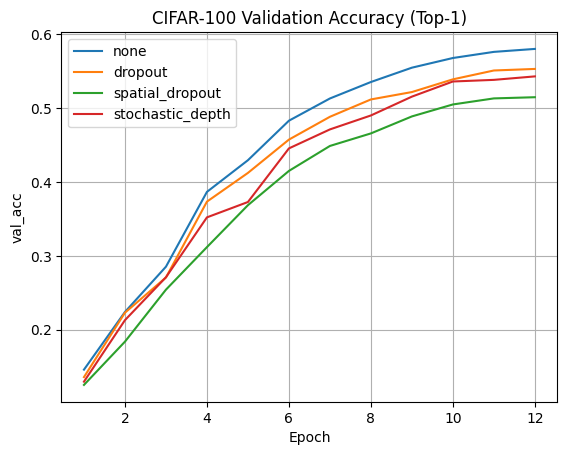

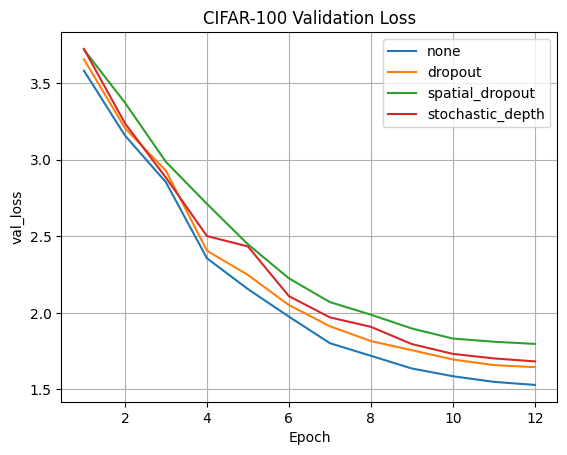

In [7]:

# ===== 6) Summary + Plots =====
def last_metrics(hist):
    h = hist[-1]
    return h["val_acc"], h["val_loss"]

print("\n=== LAST EPOCH SUMMARY ===")
for name, hist in all_hist.items():
    va, vl = last_metrics(hist)
    print(f"{name:16s} | val_acc={va:.4f} | val_loss={vl:.4f}")

def plot_key(key, title):
    plt.figure()
    for name, hist in all_hist.items():
        xs = [r["epoch"] for r in hist]
        ys = [r[key] for r in hist]
        plt.plot(xs, ys, label=name)
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_key("val_acc",  "CIFAR-100 Validation Accuracy (Top-1)")
plot_key("val_loss", "CIFAR-100 Validation Loss")

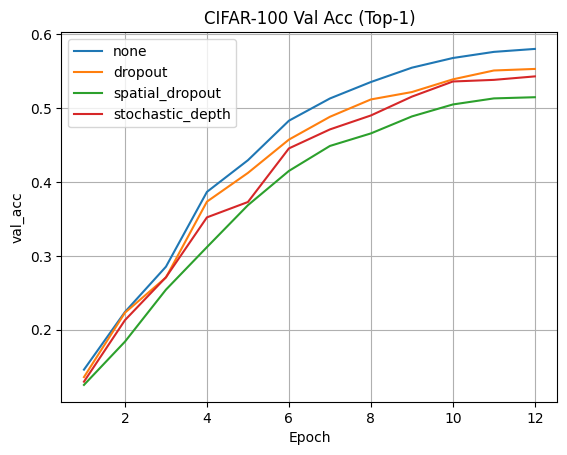

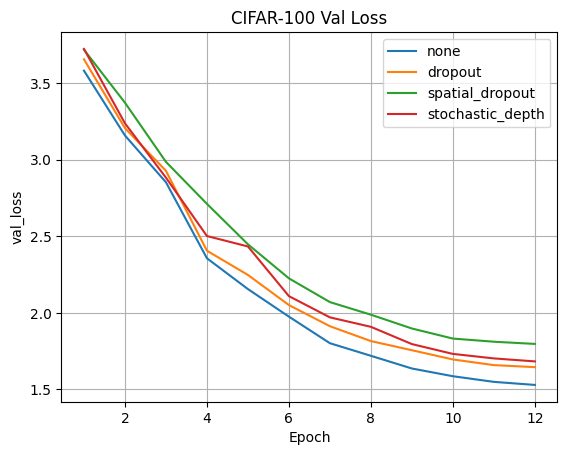

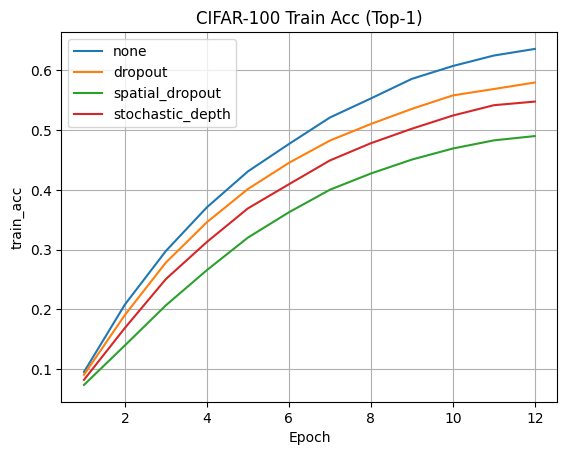

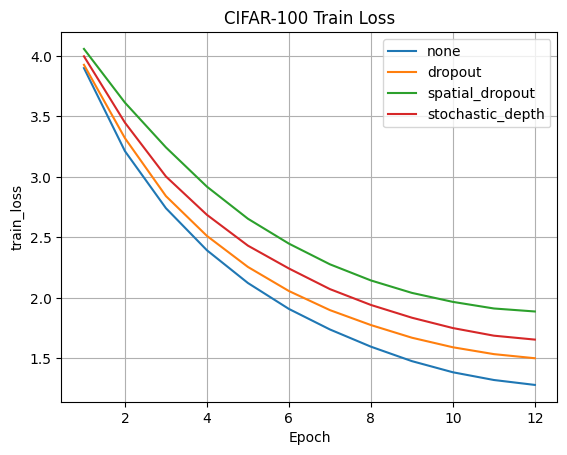

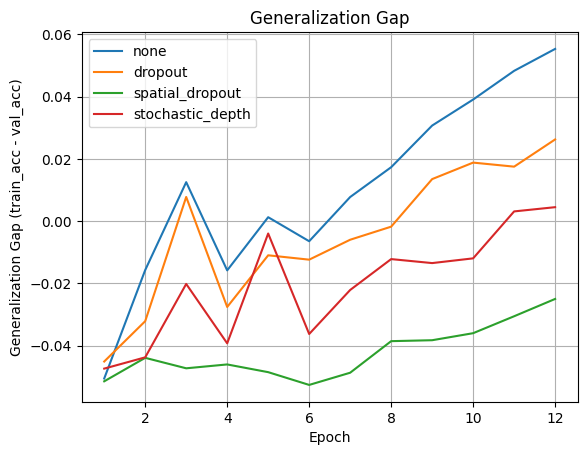

In [8]:
import matplotlib.pyplot as plt

def plot_metric(all_hist, key, title=None):
    plt.figure()
    for name, hist in all_hist.items():
        xs = [r["epoch"] for r in hist]
        ys = [r[key] for r in hist]
        plt.plot(xs, ys, label=name)
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.title(title if title else key)
    plt.legend()
    plt.grid(True)
    plt.show()

# 1) Validation Accuracy
plot_metric(all_hist, "val_acc", "CIFAR-100 Val Acc (Top-1)")

# 2) Validation Loss
plot_metric(all_hist, "val_loss", "CIFAR-100 Val Loss")

# 3) Train Accuracy
plot_metric(all_hist, "train_acc", "CIFAR-100 Train Acc (Top-1)")

# 4) Train Loss
plot_metric(all_hist, "train_loss", "CIFAR-100 Train Loss")


def plot_gap(all_hist):
    plt.figure()
    for name, hist in all_hist.items():
        xs = [r["epoch"] for r in hist]
        gap = [r["train_acc"] - r["val_acc"] for r in hist]
        plt.plot(xs, gap, label=name)
    plt.xlabel("Epoch")
    plt.ylabel("Generalization Gap (train_acc - val_acc)")
    plt.title("Generalization Gap")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_gap(all_hist)

# 📊 Sonuç Analizi

## Neden Baseline (None) En İyi Çıktı?

### 1️⃣ Eğitim Süresi Çok Kısa (12 Epoch)

Model henüz ciddi bir **overfitting** aşamasına ulaşmadı.  
Train accuracy ile validation accuracy arasındaki fark (gap) yaklaşık **%5 civarında**.

Bu küçük bir farktır.  
Yani model regularization’a ihtiyaç duymuyor.

---

### 2️⃣ Regularization Ne Yapar?

Dropout, Spatial Dropout ve Stochastic Depth:

- Model kapasitesini bilinçli olarak düşürür.
- Öğrenmeyi zorlaştırır.
- Amaç: Overfitting'i azaltmak.

Ancak model zaten overfit değilse:

> Regularization → Underfitting'e yol açar.

Bu yüzden accuracy düştü.

---

### 3️⃣ Dropout (p=0.2)

- Küçük CNN + kısa eğitim süresi için agresif.
- Öğrenme hızını düşürdü.
- Validation performansı baseline’ın altında kaldı.

---

### 4️⃣ Spatial Dropout

- Kanal bazlı komple feature map’leri sıfırlar.
- CIFAR-100 gibi düşük çözünürlüklü veri setlerinde erken aşamada ağır gelir.
- Bu yüzden en düşük validation accuracy burada görüldü.

---

### 5️⃣ Stochastic Depth

- Block-level regularization yapar.
- Derin ağlar ve uzun eğitimlerde daha anlamlıdır.
- Küçük model + 12 epoch kombinasyonunda avantaj göstermedi.

---

# 🎯 Genel Sonuç

Bu deney şunu gösteriyor:

> Regularization teknikleri her zaman accuracy artırmaz.

Model overfit değilse regularization performansı düşürebilir.

---
